In [1]:
# Taken from: https://www.kaggle.com/headsortails/pytanic

# Import the modules

import pandas as pd
import numpy as np
from scipy import stats
import sklearn as sk
import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn import svm
#import xgboost as xgb
#from mlxtend.classifier import StackingClassifier #need to install manually

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split # why? the data is already split into test and train
from sklearn.model_selection import GridSearchCV

sns.set(style='white', context='notebook', palette='deep') #maybe undo style

#in addition, add modules from iris
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier


In [2]:
#Load the data and combine in order to explore a larger dataset. Drop 'survive' as it's not contained in test
train = pd.read_csv('C:/Users/akosciansky/Desktop/Kaggle/Titanic/train (2).csv')
test = pd.read_csv('C:/Users/akosciansky/Desktop/Kaggle/Titanic/test (1).csv')
combine = pd.concat([train.drop('Survived', 1), test])

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
#Missing values of train
print(train.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [6]:
#Missing values of test
print(test.isnull().sum())

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [7]:
#Calculate the baseline prediction accuracy
#colour code survival
surv = train[train['Survived']==1]
nosurv = train[train['Survived']==0]
surv_col = 'blue'
nosurv_col = 'red'

print('Survived: %i (%.1f percent), Not survived: %i (%.1f percent), Total: %i'\
     %(len(surv), 1.*len(surv)/len(train)*100.0,\
      len(nosurv), 1.*len(nosurv)/len(train)*100.0, len(train)))

Survived: 342 (38.4 percent), Not survived: 549 (61.6 percent), Total: 891


Median age survivors: 28.0, Median age non-survivors: 28.0


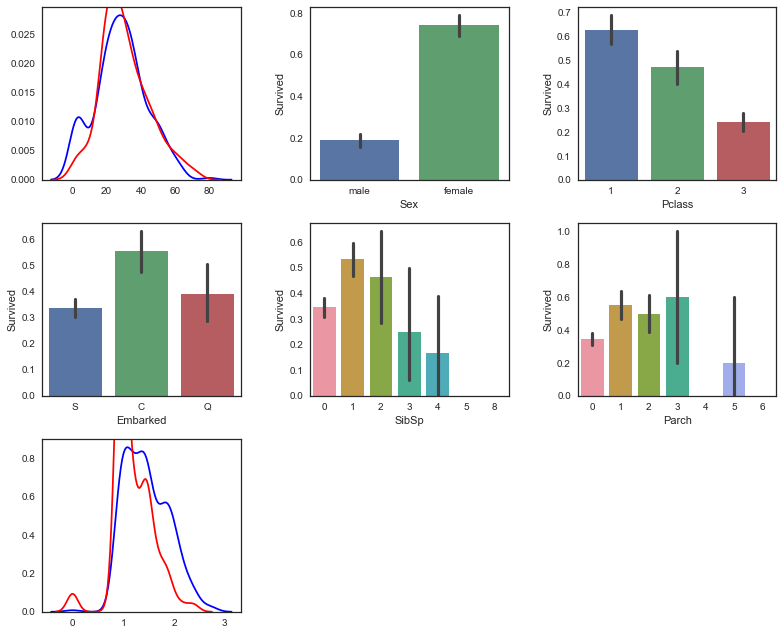

In [8]:
#plot the variables against their survival rates
warnings.filterwarnings('ignore')
plt.figure(figsize=[12,10])
plt.subplot(331)
sns.kdeplot(surv['Age'].dropna().values, color=surv_col)
sns.kdeplot(nosurv['Age'].dropna().values, color=nosurv_col)
plt.subplot(332)
sns.barplot('Sex', 'Survived', data=train)
plt.subplot(333)
sns.barplot('Pclass', 'Survived', data=train)
plt.subplot(334)
sns.barplot('Embarked', 'Survived', data=train)
plt.subplot(335)
sns.barplot('SibSp', 'Survived', data=train)
plt.subplot(336)
sns.barplot('Parch', 'Survived', data=train)
plt.subplot(337)
sns.kdeplot(np.log10(surv['Fare'].dropna().values+1), color=surv_col)
sns.kdeplot(np.log10(nosurv['Fare'].dropna().values+1), color=nosurv_col)
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)

print('Median age survivors: %.1f, Median age non-survivors: %.1f'\
     %(np.median(surv['Age'].dropna()), np.median(nosurv['Age'].dropna())))

In [9]:
#The error rates within SibSp and Parch overlap. so let's test whether it really makes a difference with how many people you travel
tab = pd.crosstab(train['SibSp'], train['Survived'])
print(tab)

Survived    0    1
SibSp             
0         398  210
1          97  112
2          15   13
3          12    4
4          15    3
5           5    0
8           7    0


In [10]:
#Let's estimate whether the survival rates are statistically significant
#x = no. of non-survivors
#n = total no. of passenger in that category
#p= non-survival rate; calculated further up

print('Avg Survival rate: 38pc')
print('0: %ipc - p-value: %.2f' %(210/(210+398)*100, stats.binom_test(x=398, n=608, p=0.62)))
print('1: %ipc - p-value: %.2f' %(112/(112+97)*100, stats.binom_test(x=97, n=209, p=0.62)))
print('2: %ipc - p-value: %.2f' %(13/(13+15)*100, stats.binom_test(x=15, n=28, p=0.62)))
print('3: %ipc - p-value: %.2f' %(4/(4+12)*100, stats.binom_test(x=12, n=16, p=0.62)))
print('4: %ipc - p-value: %.2f' %(3/(3+15)*100, stats.binom_test(x=15, n=18, p=0.62)))
print('5: %ipc - p-value: %.2f' %(0, stats.binom_test(x=5, n=5, p=0.62)))
print('8: %ipc - p-value: %.2f' %(0, stats.binom_test(x=7, n=7, p=0.62)))

Avg Survival rate: 38pc
0: 34pc - p-value: 0.08
1: 53pc - p-value: 0.00
2: 46pc - p-value: 0.44
3: 25pc - p-value: 0.44
4: 16pc - p-value: 0.09
5: 0pc - p-value: 0.16
8: 0pc - p-value: 0.05


In [11]:
#The error rates within SibSp and Parch overlap. so let's test whether it really makes a difference with how many people you travel
tab = pd.crosstab(train['Parch'], train['Survived'])
print(tab)

Survived    0    1
Parch             
0         445  233
1          53   65
2          40   40
3           2    3
4           4    0
5           4    1
6           1    0


In [12]:
print('Avg Survival rate: 38pc')
print('0: %ipc - p-value: %.2f' %(233/(233+445)*100, stats.binom_test(x=233, n=(233+445), p=0.62)))
print('1: %ipc - p-value: %.2f' %(65/(65+53)*100, stats.binom_test(x=65, n=(65+53), p=0.62)))
print('2: %ipc - p-value: %.2f' %(40/(40+40)*100, stats.binom_test(x=40, n=(40+40), p=0.62)))
print('3: %ipc - p-value: %.2f' %(3/(3+2)*100, stats.binom_test(x=3, n=(3+2), p=0.62)))
print('4: %ipc - p-value: %.2f' %(0*100, stats.binom_test(x=0, n=4, p=0.62)))
print('5: %ipc - p-value: %.2f' %(1/(1+5)*100, stats.binom_test(x=1, n=5, p=0.62)))
print('6: %ipc - p-value: %.2f' %(0*100, stats.binom_test(x=0, n=1, p=0.62)))

Avg Survival rate: 38pc
0: 34pc - p-value: 0.00
1: 55pc - p-value: 0.13
2: 50pc - p-value: 0.03
3: 60pc - p-value: 1.00
4: 0pc - p-value: 0.02
5: 16pc - p-value: 0.07
6: 0pc - p-value: 0.38


In [13]:
#Cabin numbers
train.loc[:, ['Cabin']].dropna().head(10)

,Cabin
1,C85
3,C123
6,E46
10,G6
11,C103
21,D56
23,A6
27,C23 C25 C27
31,B78
52,D33


In [14]:
#Unique values of cabin letters 
train['Cabin'].dropna().str[:1].unique()

#Can I count the number of cabins for each letter? 
#What's up with multiple cabins per person? did family members live in there?

array(['C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [15]:
#Ticket numbers
print('Unique tickets: %i' %(train['Ticket'].nunique())) #nunique() required because unique() creates a numpy.ndarray rather than a number
print('Total tickets: %i' %(train['Ticket'].count()))

Unique tickets: 681
Total tickets: 891


In [16]:
# Ticket number might be a better predictor than family name and many people seem to share the same ticket
grouped = train.groupby('Ticket')
k = 0
for name, group in grouped:
    if(len(grouped.get_group(name)) > 1):
        print(group.loc[:,['Survived', 'Name', 'Fare']])
        k += 1
    if (k>10):
        break

     Survived                                               Name  Fare
257         1                               Cherry, Miss. Gladys  86.5
504         1                              Maioni, Miss. Roberta  86.5
759         1  Rothes, the Countess. of (Lucy Noel Martha Dye...  86.5
     Survived                                    Name   Fare
262         0                       Taussig, Mr. Emil  79.65
558         1  Taussig, Mrs. Emil (Tillie Mandelbaum)  79.65
585         1                     Taussig, Miss. Ruth  79.65
     Survived                            Name  Fare
110         0  Porter, Mr. Walter Chamberlain  52.0
475         0     Clifford, Mr. George Quincy  52.0
     Survived                                             Name     Fare
329         1                     Hippach, Miss. Jean Gertrude  57.9792
523         1  Hippach, Mrs. Louis Albert (Ida Sophia Fischer)  57.9792
     Survived                                    Name  Fare
166         1  Chibnall, Mrs. (Edith Mar

In [17]:
#Alternatively I can use this code - I don't understand this piece of code
grouped = train.groupby('Ticket')
#np.where(grouped.groupby('Ticket')['Name'].transform('count') > 1, 1, 0)
np.where(combine.groupby('Ticket')['Name'].transform('count') > 1, 1, 0)

array([0, 1, 0, ..., 0, 0, 1])

In [18]:
# Relations between features

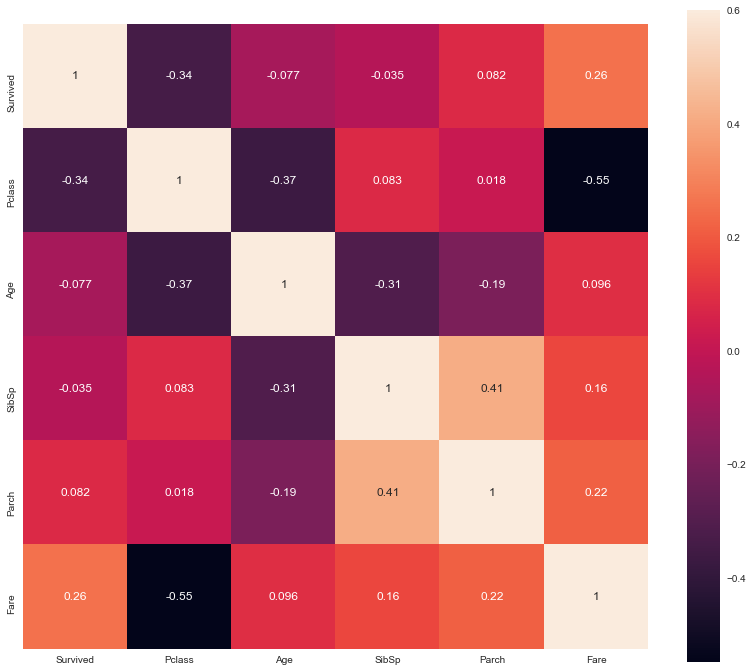

In [19]:
#Drop Id and get correlations for continuous features - these are actually almost all multinomial features; correlation shouldnt'
#make that much sense
plt.figure(figsize=(14,12))
sns.heatmap(train.drop('PassengerId', axis=1).corr(), vmax=0.6, square=True, annot=True)

Text(0.5,0,'Female Survival')

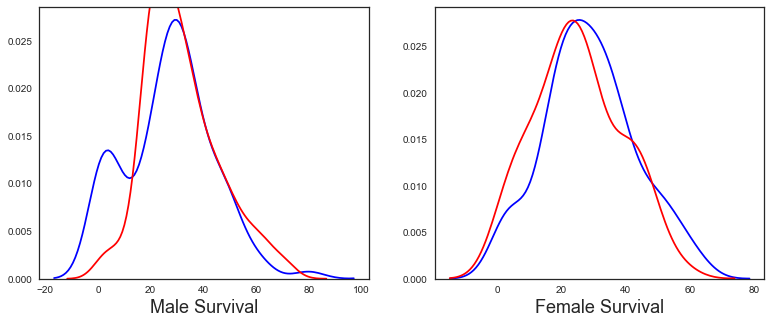

In [20]:
msurv = train[(train['Survived']==1) & (train['Sex']=='male')]
mnosurv = train[(train['Survived']==0) & (train['Sex']=='male')]
fsurv = train[(train['Survived']==1) & (train['Sex']=='female')]
fnosurv = train[(train['Survived']==0) & (train['Sex']=='female')]
surv_col = 'blue'
nosurv_col = 'red'

warnings.filterwarnings('ignore')
plt.figure(figsize=[13,5])

plt.subplot(121)
sns.kdeplot(msurv['Age'].dropna().values, color=surv_col)
sns.kdeplot(mnosurv['Age'].dropna().values, color=nosurv_col)
plt.xlabel('Male Survival', fontsize=18)


plt.subplot(122)
sns.kdeplot(fsurv['Age'].dropna().values, color=surv_col)
sns.kdeplot(fnosurv['Age'].dropna().values, color=nosurv_col)
plt.xlabel('Female Survival', fontsize=18)

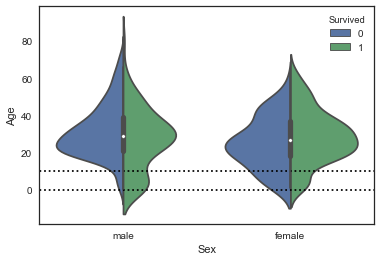

In [21]:
#Survival rates by sex and age using violin plot

sns.violinplot(x='Sex', y='Age', hue='Survived', data=train, split=True)
plt.hlines([0,10], xmin=-1, xmax=3, linestyles='dotted')

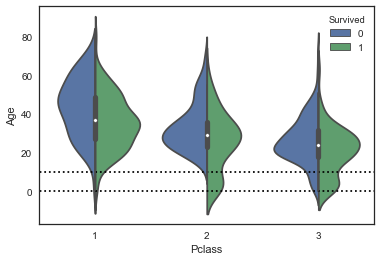

In [22]:
#Survival rates by age and Pclass using violin plot

sns.violinplot(x='Pclass', y='Age', hue='Survived', data=train, split=True)
plt.hlines([0,10], xmin=-1, xmax=3, linestyles='dotted')

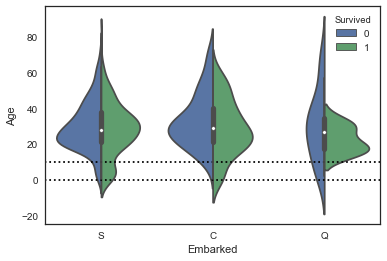

In [23]:
#Survival rates by age and embarked using violin plot

sns.violinplot(x='Embarked', y='Age', hue='Survived', data=train, split=True)
plt.hlines([0,10], xmin=-1, xmax=3, linestyles='dotted')

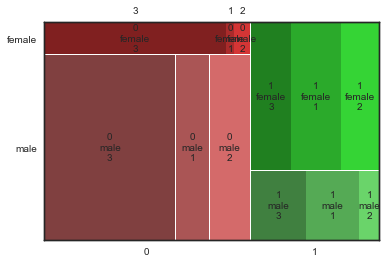

In [24]:
#For two categorical values a mosaic plot is more appropriate or can use a factorplot
dummy = mosaic(train, ['Survived', 'Sex', 'Pclass'])

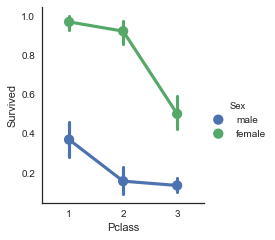

In [25]:
#Factorplot instead where we can encode 4 variables
g = sns.factorplot(x='Pclass', y='Survived', hue='Sex', data=train, aspect=0.9, size=3.5, ci=95.0)

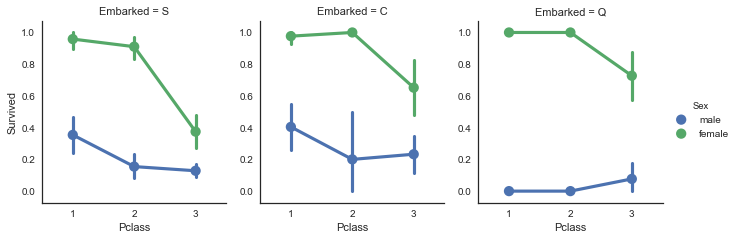

In [26]:
#Factorplot instead where we can encode 4 variables - entension
g = sns.factorplot(x='Pclass', y='Survived', hue='Sex', col='Embarked', data=train, aspect=0.9, size=3.5, ci=95.0)

In [27]:
#Skip some visualisations

In [28]:
#Feature engineering - age, cabin, and embarkment have missing values

In [29]:
#Filling in missing data - 'Embarked'
print(train[train['Embarked'].isnull()])

     PassengerId  Survived  Pclass                                       Name  \
61            62         1       1                        Icard, Miss. Amelie   
829          830         1       1  Stone, Mrs. George Nelson (Martha Evelyn)   

        Sex   Age  SibSp  Parch  Ticket  Fare Cabin Embarked  
61   female  38.0      0      0  113572  80.0   B28      NaN  
829  female  62.0      0      0  113572  80.0   B28      NaN  


In [30]:
#Let's see what 'Embarked' is associated with people with the same features
combine.where((combine['Pclass']==1) & \
             (combine['Sex']=='female')).groupby(['Embarked', 'Pclass', 'Sex', 'Parch', 'SibSp']).size()

#combine.where((combine['Embarked']!='Q') & (combine['Pclass']<1.5) & \
             #(combine['Sex']=='female')).groupby(['Embarked', 'Pclass', 'Sex', 'Parch', 'SibSp']).size()

Embarked  Pclass  Sex     Parch  SibSp
C         1.0     female  0.0    0.0      30
                                 1.0      20
                          1.0    0.0      10
                                 1.0       6
                          2.0    0.0       2
                                 2.0       2
                          3.0    1.0       1
Q         1.0     female  0.0    1.0       2
S         1.0     female  0.0    0.0      20
                                 1.0      20
                                 2.0       3
                          1.0    0.0       7
                                 1.0       6
                          2.0    0.0       4
                                 1.0       5
                                 3.0       3
                          4.0    1.0       1
dtype: int64

In [31]:
#C has 30 cases whereas S only has 20 -> impute C
train['Embarked'].iloc[61] = 'C'
train['Embarked'].iloc[829] = 'C'
print(train.iloc[61])

PassengerId                     62
Survived                         1
Pclass                           1
Name           Icard, Miss. Amelie
Sex                         female
Age                             38
SibSp                            0
Parch                            0
Ticket                      113572
Fare                            80
Cabin                          B28
Embarked                         C
Name: 61, dtype: object


In [32]:
#Filling in missing data - 'Fare'
print(test[test['Fare'].isnull()])

     PassengerId  Pclass                Name   Sex   Age  SibSp  Parch Ticket  \
152         1044       3  Storey, Mr. Thomas  male  60.5      0      0   3701   

     Fare Cabin Embarked  
152   NaN   NaN        S  


In [33]:
#For simplicity, just use median fare
test['Fare'].iloc[152] = combine['Fare'][combine['Pclass']==3].dropna().median()
print(test.iloc[152])

PassengerId                  1044
Pclass                          3
Name           Storey, Mr. Thomas
Sex                          male
Age                          60.5
SibSp                           0
Parch                           0
Ticket                       3701
Fare                         8.05
Cabin                         NaN
Embarked                        S
Name: 152, dtype: object


In [34]:
#Filling in missing data - 'Cabin'
train[train['Cabin'].isnull()].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S


In [35]:
#Remove NaNs
cabin = combine
cabin = cabin[cabin['Cabin'].notnull()]
cabin.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


In [36]:
#Replace cabins with unique values of cabin letters 
cabin['Cabin'] = cabin['Cabin'].str[:1]
cabin.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S
6,7,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E,S
10,11,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G,S
11,12,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C,S


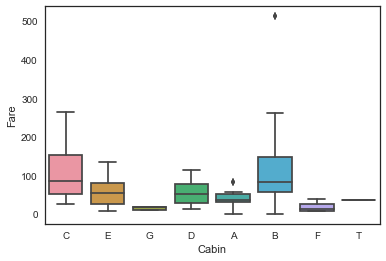

In [37]:
#Boxplots for Cabin and Fare
#cabin_grouped = cabin.groupby(['Cabin'])
#plt.figure()
#cabin_grouped.median().sort_values(['Fare']).plot(kind='bar')
#cabin_grouped.head()

#cabin_sorted = cabin.median().sort_values(['Fare'], axis=1,na_position="first")
#cabin_sorted.head(15)

sns.boxplot(x='Cabin', y='Fare', data=cabin)

In [38]:
cabin.groupby('Cabin').median()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
Cabin,,,,,,
A,615.5,1.0,41.0,0.0,0.0,35.0771
B,731.0,1.0,35.0,0.0,0.0,82.2667
C,640.0,1.0,37.0,1.0,0.0,86.2896
D,653.0,1.0,42.0,0.0,0.0,52.5542
E,586.0,1.0,39.0,0.0,0.0,53.1000
F,700.0,2.0,24.5,0.0,0.0,13.0000
G,252.0,3.0,4.0,1.0,1.0,16.7000
T,340.0,1.0,45.0,0.0,0.0,35.5000


In [39]:
#Feature Engineering

combine = pd.concat([train.drop('Survived', 1), test])
survived = train['Survived']

#combine.head()
combine['Child'] = combine['Age'] <= 10
combine['Cabin_known'] = combine['Cabin'].isnull() == False
combine['Age_known'] = combine['Age'].isnull() == False
combine['Family'] = combine['SibSp'] + combine['Parch']
combine['Alone'] = (combine['SibSp'] + combine['Parch']) == 0
combine['Large_Family'] = (combine['SibSp'] > 2) | (combine['Parch'] > 3)
combine['Deck'] = combine['Cabin'].str[0]
combine['Deck'] = combine['Deck'].fillna(value='U')
combine['Ttype'] = combine['Ticket'].str[0]
combine['Title'] = combine['Name'].str.split(", ", expand=True)[1].str.split(", ", expand=True)[0]
combine['Fare_cat'] = pd.DataFrame(np.floor(np.log10(combine['Fare'] + 1))).astype('int')
combine['Bad_ticket'] = combine['Ttype'].isin(['3','4','5','6','7','8','A','L','W'])
combine['Young'] = (combine['Age']<=30) | (combine['Title'].isin(['Master', 'Miss', 'Mlle']))
combine['Shared_ticket'] = np.where(combine.groupby('Ticket')['Name'].transform('count') > 1, 1, 0)
combine['Ticket_group'] = combine.groupby('Ticket')['Name'].transform('count')
combine['Fare_eff'] = combine['Fare']/combine['Ticket_group']
combine['Fare_eff_cat'] = np.where(combine['Fare_eff']>16.0, 2, 1)
test = combine.iloc[len(train):]
train = combine.iloc[:len(train)]
train['Survived'] = survived

surv = train[train['Survived'] == 1]
nosurv = train[train['Survived'] == 0]


combine.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Deck,Ttype,Title,Fare_cat,Bad_ticket,Young,Shared_ticket,Ticket_group,Fare_eff,Fare_eff_cat
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,...,U,A,Mr. Owen Harris,0,True,True,0,1,7.25000,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,...,C,P,Mrs. John Bradley (Florence Briggs Thayer),1,False,False,1,2,35.64165,2
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,...,U,S,Miss. Laina,0,False,True,0,1,7.92500,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,...,C,1,Mrs. Jacques Heath (Lily May Peel),1,False,False,1,2,26.55000,2
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,...,U,3,Mr. William Henry,0,True,False,0,1,8.05000,1


In [40]:
combine[['Ticket', 'Ticket_group', 'Shared_ticket']].head()

,Ticket,Ticket_group,Shared_ticket
0,A/5 21171,1,0
1,PC 17599,2,1
2,STON/O2. 3101282,1,0
3,113803,2,1
4,373450,1,0


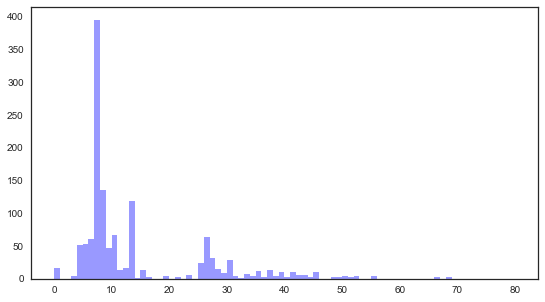

In [41]:
plt.figure(figsize=[20,5])
plt.subplot(121)
sns.distplot(combine['Fare_eff'].dropna().values, bins=range(0, 81, 1), kde=False, color=surv_col)

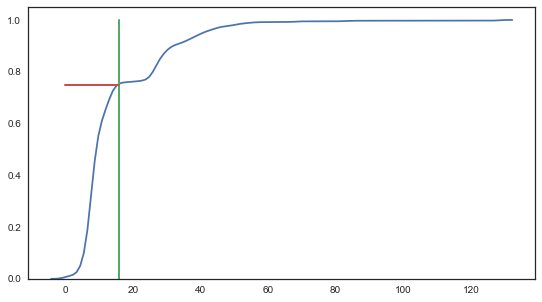

In [42]:
plt.figure(figsize=[20,5])
plt.subplot(121)
sns.kdeplot(combine['Fare_eff'].dropna().values, cumulative = True)
plt.plot([16, 16], [0, 1], linewidth=2)
plt.plot([0, 16], [0.75, 0.75], linewidth=2)

In [43]:
combine['Title'] = combine['Name'].str.split(", ", expand=True)[1].str.split(". ", expand=True)[0]

print(combine['Age'].groupby(combine['Title']).count())
print(combine['Age'].groupby(combine['Title']).mean())

print("There are %i unique titles in total."%(len(combine['Title'].unique())))

Title
Capt          1
Col           4
Don           1
Dona          1
Dr            7
Jonkheer      1
Lady          1
Major         2
Master       53
Miss        210
Mlle          2
Mme           1
Mr          581
Mrs         170
Ms            1
Rev           8
Sir           1
th            1
Name: Age, dtype: int64
Title
Capt        70.000000
Col         54.000000
Don         40.000000
Dona        39.000000
Dr          43.571429
Jonkheer    38.000000
Lady        48.000000
Major       48.500000
Master       5.482642
Miss        21.774238
Mlle        24.000000
Mme         24.000000
Mr          32.252151
Mrs         36.994118
Ms          28.000000
Rev         41.250000
Sir         49.000000
th          33.000000
Name: Age, dtype: float64
There are 18 unique titles in total.


In [44]:
train['Name']

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
5                                       Moran, Mr. James
6                                McCarthy, Mr. Timothy J
7                         Palsson, Master. Gosta Leonard
8      Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                    Nasser, Mrs. Nicholas (Adele Achem)
10                       Sandstrom, Miss. Marguerite Rut
11                              Bonnell, Miss. Elizabeth
12                        Saundercock, Mr. William Henry
13                           Andersson, Mr. Anders Johan
14                  Vestrom, Miss. Hulda Amanda Adolfina
15                      Hewlett, Mrs. (Mary D Kingcome) 
16                                  Rice, Master. Eugene
17                          Wil

In [45]:
combine = pd.concat([train.drop('Survived',1),test])
survived = train['Survived']

combine["Sex"] = combine["Sex"].astype("category")
combine["Sex"].cat.categories = [0,1]
combine["Sex"] = combine["Sex"].astype("int")
combine["Embarked"] = combine["Embarked"].astype("category")
combine["Embarked"].cat.categories = [0,1,2]
combine["Embarked"] = combine["Embarked"].astype("int")
combine["Deck"] = combine["Deck"].astype("category")
combine["Deck"].cat.categories = [0,1,2,3,4,5,6,7,8]
combine["Deck"] = combine["Deck"].astype("int")

test = combine.iloc[len(train):]
train = combine.iloc[:len(train)]
train['Survived'] = survived

train.loc[:,["Sex","Embarked"]].head()

,Sex,Embarked
0,1,2
1,0,0
2,0,2
3,0,2
4,1,2


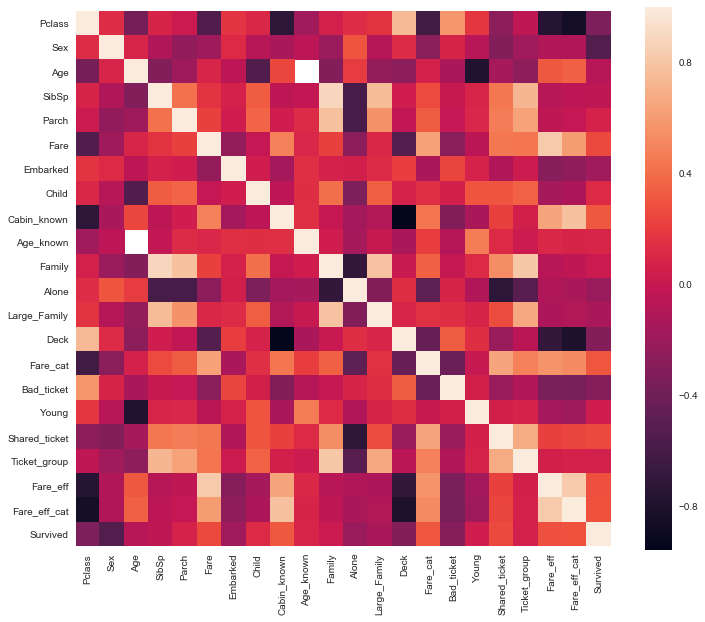

In [46]:
ax = plt.subplots( figsize =( 12 , 10 ) )
foo = sns.heatmap(train.drop('PassengerId',axis=1).corr(), vmax=1.0, square=True, annot=False)

# Modelling

In [47]:
training, testing = train_test_split(train, test_size=0.2, random_state=0)
print("Total sample size = %i; training sample size = %i, testing sample size = %i"\
     %(train.shape[0],training.shape[0],testing.shape[0]))

Total sample size = 891; training sample size = 712, testing sample size = 179


In [48]:
#Logistic Regression

In [49]:
cols = ['Sex','Pclass','Cabin_known','Large_Family','Parch',
        'SibSp','Young','Alone','Shared_ticket','Child']
tcols = np.append(['Survived'],cols)

df = training.loc[:,tcols].dropna()
X = df.loc[:,cols]
y = np.ravel(df.loc[:,['Survived']])

In [50]:
clf_log = LogisticRegression()
clf_log = clf_log.fit(X,y)
score_log1 = clf_log.score(X,y)
#score_log = cross_val_score(clf_log, X, y, cv=5).mean()
print(score_log1)

0.813202247191


In [51]:
pd.DataFrame(list(zip(X.columns, np.transpose(clf_log.coef_))))

,0,1
0,Sex,[-2.53136573861]
1,Pclass,[-0.528089412655]
2,Cabin_known,[0.666661582993]
3,Large_Family,[-1.42117469116]
4,Parch,[-0.0371646996211]
5,SibSp,[-0.236930061316]
6,Young,[0.292179313174]
7,Alone,[-0.0214310328819]
8,Shared_ticket,[0.169394895603]
9,Child,[1.46227097122]


In [52]:
#Logistic Regression with fewer variables

In [53]:
cols = ['Sex','Pclass','Cabin_known','Large_Family','Shared_ticket','Young','Alone','Child']
tcols = np.append(['Survived'],cols)

df = training.loc[:,tcols].dropna()
X = df.loc[:,cols]
y = np.ravel(df.loc[:,['Survived']])

df_test = testing.loc[:,tcols].dropna()
X_test = df_test.loc[:,cols]
y_test = np.ravel(df_test.loc[:,['Survived']])

In [54]:
clf_log = LogisticRegression()
clf_log = clf_log.fit(X,y)
score_log2 = cross_val_score(clf_log, X, y, cv=5).mean()
print(score_log2)

0.804902160071


In [55]:
#Perceptron

In [56]:
clf_pctr = Perceptron(
    class_weight='balanced'
    )
clf_pctr = clf_pctr.fit(X,y)
score_pctr = cross_val_score(clf_pctr, X, y, cv=5).mean()
print(score_pctr)

0.781076689767


In [57]:
#K Neareast Neighbours

In [58]:
clf_knn = KNeighborsClassifier(
    n_neighbors=10,
    weights='distance'
    )
clf_knn = clf_knn.fit(X,y)
score_knn = cross_val_score(clf_knn, X, y, cv=5).mean()
print(score_knn)

0.801857048156


In [59]:
#Support Vector Machine

In [60]:
clf_svm = svm.SVC(
    class_weight='balanced'
    )
clf_svm.fit(X, y)
score_svm = cross_val_score(clf_svm, X, y, cv=5).mean()
print(score_svm)

0.824531965886


In [61]:
#Bagging

In [62]:
bagging = BaggingClassifier(
    KNeighborsClassifier(
        n_neighbors=2,
        weights='distance'
        ),
    oob_score=True,
    max_samples=0.5,
    max_features=1.0
    )
clf_bag = bagging.fit(X,y)
score_bag = clf_bag.oob_score_
print(score_bag)

0.806179775281


In [63]:
#Decision Tree

In [64]:
clf_tree = tree.DecisionTreeClassifier(
    #max_depth=3,\
    class_weight="balanced",\
    min_weight_fraction_leaf=0.01\
    )
clf_tree = clf_tree.fit(X,y)
score_tree = cross_val_score(clf_tree, X, y, cv=5).mean()
print(score_tree)

0.81332331638


In [65]:
#Random Forest

In [66]:
clf_rf = RandomForestClassifier(
    n_estimators=1000, \
    max_depth=None, \
    min_samples_split=10 \
    #class_weight="balanced", \
    #min_weight_fraction_leaf=0.02 \
    )
clf_rf = clf_rf.fit(X,y)
score_rf = cross_val_score(clf_rf, X, y, cv=5).mean()
print(score_rf)

0.824452472909


In [125]:
clf_rf.predict(X)

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0,

In [123]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Deck,Ttype,Title,Fare_cat,Bad_ticket,Young,Shared_ticket,Ticket_group,Fare_eff,Fare_eff_cat
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,NaN,...,8,3,Mr,0,True,False,0,1,7.82920,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,7.0000,NaN,...,8,3,Mrs,0,True,False,0,1,7.00000,1
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,9.6875,NaN,...,8,2,Mr,1,False,False,0,1,9.68750,1
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,8.6625,NaN,...,8,3,Mr,0,True,True,0,1,8.66250,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,3101298,12.2875,NaN,...,8,3,Mrs,1,True,True,1,2,6.14375,1


In [ ]:
test = test.fillna(train.mean())
test.loc[:,'Sex'] = test.loc[:,'Sex'].map( {'female': 0, 'male': 1} ).astype(int)

In [126]:
output = list(zip(test.loc[:,'PassengerId'],clf_rf.predict(X)))

In [127]:
submit = pd.DataFrame(output,columns=["PassengerId", "Survived"])

In [130]:
submit.to_csv('predictions.csv',index=False)

In [129]:
pwd

'C:\\Users\\akosciansky\\Desktop\\Jupyter Scripts'

In [67]:
#Extremely Randomised Trees

In [68]:
clf_ext = ExtraTreesClassifier(
    max_features='auto',
    bootstrap=True,
    oob_score=True,
    n_estimators=1000,
    max_depth=None,
    min_samples_split=10
    #class_weight="balanced",
    #min_weight_fraction_leaf=0.02
    )
clf_ext = clf_ext.fit(X,y)
score_ext = cross_val_score(clf_ext, X, y, cv=5).mean()
print(score_ext)

0.823053871511


In [69]:
#Gradient Boosting

In [70]:
import warnings
warnings.filterwarnings("ignore")

clf_gb = GradientBoostingClassifier(
            #loss='exponential',
            n_estimators=1000,
            learning_rate=0.1,
            max_depth=3,
            subsample=0.5,
            random_state=0).fit(X, y)
clf_gb.fit(X,y)
score_gb = cross_val_score(clf_gb, X, y, cv=5).mean()
print(score_gb)

0.816011338577


In [71]:
#Ada Boost

In [72]:
clf_ada = AdaBoostClassifier(n_estimators=400, learning_rate=0.1)
clf_ada.fit(X,y)
score_ada = cross_val_score(clf_ada, X, y, cv=5).mean()
print(score_ada)

0.807729050492


In [73]:
#eXtreme Gradient Boosting

clf_xgb = xgb.XGBClassifier(
    max_depth=2,
    n_estimators=500,
    subsample=0.5,
    learning_rate=0.1
    )
clf_xgb.fit(X,y)
score_xgb = cross_val_score(clf_xgb, X, y, cv=5).mean()
print(score_xgb)

In [77]:
models = pd.DataFrame({
        'Model' : ['Logistic Regression 1', 'Logistic Regression 2', 'Perceptron', 'KNN', 'SVM', 'Bagging', 'Decision Tree',
                   'Random Forest', 'Extra Tree', 'Gradient Boosting', 'ADA Boosting'],
        'Score' : [score_log1, score_log2, score_pctr, score_knn, score_svm, score_bag, score_tree, score_rf, score_ext, score_gb, 
                    score_ada]  
})

models = models.sort_values(by='Score', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')

In [78]:
models

,Model,Score
4,SVM,0.824532
7,Random Forest,0.824452
8,Extra Tree,0.823054
9,Gradient Boosting,0.816011
6,Decision Tree,0.813323
0,Logistic Regression 1,0.813202
10,ADA Boosting,0.807729
5,Bagging,0.806180
1,Logistic Regression 2,0.804902
3,KNN,0.801857


In [79]:
#Examining/Optimising one classifier in more detail

In [80]:
clf_ext = ExtraTreesClassifier(max_features='auto',bootstrap=True,oob_score=True)
param_grid = { "criterion" : ["gini", "entropy"],
              "min_samples_leaf" : [1, 5, 10],
              "min_samples_split" : [8, 10, 12],
              "n_estimators": [20, 50, 100]}
gs = GridSearchCV(estimator=clf_ext, param_grid=param_grid, scoring='accuracy', cv=3)
gs = gs.fit(X,y)
print(gs.best_score_)
print(gs.best_params_)

0.823033707865
{'criterion': 'gini', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 50}


In [81]:
#Use these results to increase the performance

In [82]:
clf_ext = ExtraTreesClassifier(
    max_features='auto',
    bootstrap=True,
    oob_score=True,
    criterion='gini',
    min_samples_leaf=5,
    min_samples_split=8,
    n_estimators=50
    )
clf_ext = clf_ext.fit(X,y)
score_ext = clf_ext.score(X,y)
print(score_ext)
pd.DataFrame(list(zip(X.columns, np.transpose(clf_ext.feature_importances_))) \
            ).sort_values(1, ascending=False)

0.830056179775


,0,1
0,Sex,0.545490
1,Pclass,0.139256
2,Cabin_known,0.083138
3,Large_Family,0.064371
4,Shared_ticket,0.058091
7,Child,0.054962
5,Young,0.027362
6,Alone,0.027329


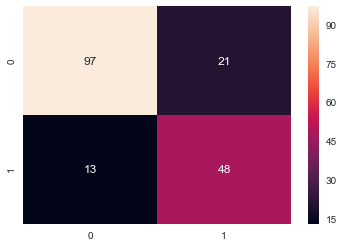

In [83]:
cnf_matrix = confusion_matrix(clf_ext.predict(X_test),y_test)
sns.heatmap(cnf_matrix, annot=True)

In [84]:
#Model validation with cross-validation

In [85]:
clf = clf_ext
scores = cross_val_score(clf, X, y, cv=5)
print(scores)
print("Mean score = %.3f, Std deviation = %.3f"%(np.mean(scores),np.std(scores)))

[ 0.7972028   0.85314685  0.79020979  0.81690141  0.84397163]
Mean score = 0.820, Std deviation = 0.025


(0, 0.5)

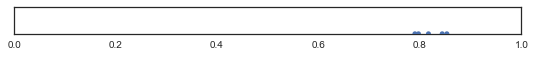

In [86]:
plt.figure(figsize=[20,0.5])
plt.subplot(121)
sns.stripplot(scores, size=5)
plt.xlim(0, 1)
plt.ylim(0, 0.5)

In [87]:
#Model validation on test set

In [88]:
score_ext_test = clf_ext.score(X_test,y_test)
print(score_ext_test)

0.810055865922


In [91]:
models = pd.DataFrame({
        'Model' : ['Logistic Regression 1', 'Logistic Regression 2', 'Perceptron', 'KNN', 'SVM', 'Bagging', 'Decision Tree',
                   'Random Forest', 'Extra Tree', 'Gradient Boosting', 'ADA Boosting'],
        'Score' : [score_log1, score_log2, score_pctr, score_knn, score_svm, score_bag, score_tree, score_rf, score_ext, score_gb, 
                    score_ada]  
})

models = models.sort_values(by='Score', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')
models

,Model,Score
8,Extra Tree,0.830056
4,SVM,0.824532
7,Random Forest,0.824452
9,Gradient Boosting,0.816011
6,Decision Tree,0.813323
0,Logistic Regression 1,0.813202
10,ADA Boosting,0.807729
5,Bagging,0.806180
1,Logistic Regression 2,0.804902
3,KNN,0.801857


In [92]:
#Feature importance by model

In [96]:
summary = pd.DataFrame(list(zip(X.columns, \
    np.transpose(clf_tree.feature_importances_), \
    np.transpose(clf_rf.feature_importances_), \
    np.transpose(clf_ext.feature_importances_), \
    np.transpose(clf_gb.feature_importances_), \
    np.transpose(clf_ada.feature_importances_), \
    )), columns=['Feature','Tree','RF','Extra','GB','Ada'])

summary['Median'] = summary.median(1)
summary.sort_values('Median', ascending=False)

,Feature,Tree,RF,Extra,GB,Ada,Median
0,Sex,0.635845,0.511019,0.545490,0.183324,0.1775,0.511019
1,Pclass,0.107525,0.156807,0.139256,0.227900,0.1600,0.156807
2,Cabin_known,0.066924,0.086898,0.083138,0.132607,0.0150,0.083138
3,Large_Family,0.096492,0.064366,0.064371,0.060627,0.1425,0.064371
7,Child,0.050168,0.062526,0.054962,0.067135,0.1475,0.062526
4,Shared_ticket,0.007203,0.047506,0.058091,0.124426,0.0975,0.058091
6,Alone,0.009925,0.040534,0.027329,0.086265,0.1725,0.040534
5,Young,0.025917,0.030343,0.027362,0.117715,0.0875,0.030343


In [97]:
#Introduct Voting and use and average of all the different models

In [101]:
clf_vote = VotingClassifier(
    estimators=[
        #('tree', clf_tree),
        ('knn', clf_knn),
        ('svm', clf_svm),
        ('extra', clf_ext),
       #('gb', clf_gb),
        #('xgb', clf_xgb),
        ('percep', clf_pctr),
        ('logistic', clf_log),
        #('RF', clf_rf),
        ],
    weights=[2,2,3,1,2],
    voting='hard')
clf_vote.fit(X,y)

scores = cross_val_score(clf_vote, X, y, cv=5, scoring='accuracy')
print("Voting: Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

#for clf, label in zip(
#    [clf_tree,clf_knn,clf_svm,clf_ext,clf_gb,clf_xgb,clf_pctr,clf_log,clf_rf,clf_bag,clf_vote],
#    ['tree','knn','svm','extra','gb','xgb','percep','logistic','RF','Bag','Ensemble']):
#    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
#    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Voting: Accuracy: 0.82 (+/- 0.04)


In [102]:
# adjust these methods to my notation:
train = X

# training and train/test split parameters
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits=NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier; this basically unifies the way we call each classifier 
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)

In [103]:
# function for out-of-fold prediction
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    # split data in NFOLDS training vs testing samples
    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        # select train and test sample
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        # train classifier on training sample
        clf.train(x_tr, y_tr)
        
        # predict classifier for testing sample
        oof_train[test_index] = clf.predict(x_te)
        # predict classifier for original test sample
        oof_test_skf[i, :] = clf.predict(x_test)
    
    # take the median of all NFOLD test sample predictions
    # (changed from mean to preserve binary classification)
    oof_test[:] = np.median(oof_test_skf,axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [104]:
# Put in our parameters for selected classifiers
# Random Forest parameters
rf_params = {
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
}

# Extra Trees Parameters
et_params = {
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [105]:
# Create objects for each classifier
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=svm.SVC, seed=SEED, params=svc_params)

In [106]:
# Create Numpy arrays of train, test and target dataframes to feed into our models
y_train = y
train = X
foo = test.loc[:,cols]
x_train = train.values 
x_test = foo.values

In [107]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

Training is complete


In [108]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'SVM' : svc_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,AdaBoost,ExtraTrees,GradientBoost,RandomForest,SVM
0,1.0,1.0,1.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0


In [109]:
base_predictions_train.describe()

,AdaBoost,ExtraTrees,GradientBoost,RandomForest,SVM
count,712.000000,712.000000,712.000000,712.000000,712.000000
mean,0.327247,0.321629,0.316011,0.306180,0.346910
std,0.469538,0.467430,0.465244,0.461229,0.476321
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


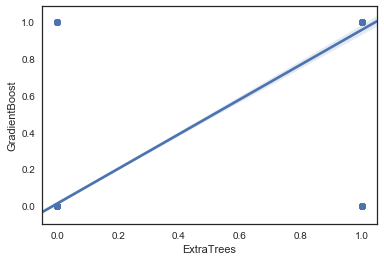

In [110]:
sns.regplot(x='ExtraTrees', y='GradientBoost' ,data=base_predictions_train)

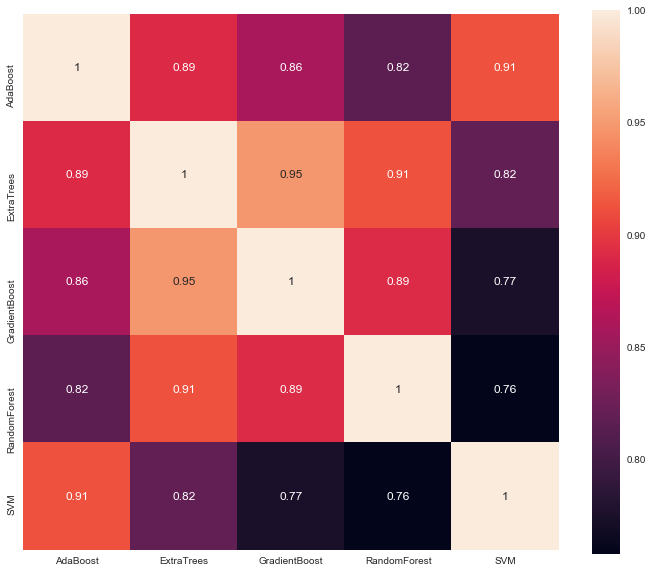

In [111]:
plt.figure(figsize=(12,10))
foo = sns.heatmap(base_predictions_train.corr(), vmax=1.0, square=True, annot=True)

In [112]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

In [113]:
x_train

array([[ 1.,  0.,  1.,  1.,  1.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.]])

clf_stack = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 scale_pos_weight=1)
clf_stack = clf_stack.fit(x_train, y_train)
stack_pred = clf_stack.predict(x_test)

scores = cross_val_score(clf_stack, x_train, y_train, cv=5)
print(scores)
print("Mean score = %.3f, Std deviation = %.3f"%(np.mean(scores),np.std(scores)))